# Intro
**Text classification** is one of the most common tasks in NLP. It is applied in a wide variety of applications, including sentiment analysis, spam filtering, news categorization, etc. Here, we show you how you can detect fake news (classifying an article as REAL or FAKE) using the state-of-the-art models, a tutorial that can be extended to really any text classification task.

The ***Transformer*** is the basic building block of most current state-of-the-art architectures of NLP. Its primary advantage is its multi-head attention mechanisms which allow for an increase in performance and significantly more parallelization than previous competing models such as recurrent neural networks. In this tutorial, we will use pre-trained BERT, one of the most popular transformer models, and fine-tune it on fake news detection.

##Getting Started

We will be using Pytorch so make sure Pytorch is installed. After ensuring relevant libraries are installed, you can install the transformers library by:

In [1]:
!pip install transformers

In [2]:
!pip install -U torchtext==0.8.0

Requirement already up-to-date: torchtext==0.8.0 in /usr/local/lib/python3.7/dist-packages (0.8.0)


# Downloading data and preprocessing

In [51]:
#  download this file from here 'https://www.kaggle.com/nopdev/real-and-fake-news-dataset'
raw_data_path = 'news.csv'

source_folder = '/'
# destination folder
destination_folder = '/'

train_test_ratio = 0.10
train_valid_ratio = 0.80

first_n_words = 200


In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split

def trim_string(x):

    x = x.split(maxsplit=first_n_words)
    x = ' '.join(x[:first_n_words])

    return x


In [53]:
# Read raw data
df_raw = pd.read_csv(raw_data_path)


# Prepare columns
df_raw['label'] = (df_raw['label'] == 'FAKE').astype('int')
df_raw['titletext'] = df_raw['title'] + ". " + df_raw['text']
df_raw = df_raw.reindex(columns=['label', 'title', 'text', 'titletext'])

# Drop rows with empty text
df_raw.drop( df_raw[df_raw.text.str.len() < 5].index, inplace=True)

# Trim text and titletext to first_n_words
df_raw['text'] = df_raw['text'].apply(trim_string)
df_raw['titletext'] = df_raw['titletext'].apply(trim_string) 

# Split according to label
df_real = df_raw[df_raw['label'] == 0]
df_fake = df_raw[df_raw['label'] == 1]

# Train-test split
df_real_full_train, df_real_test = train_test_split(df_real, train_size = train_test_ratio, random_state = 1)
df_fake_full_train, df_fake_test = train_test_split(df_fake, train_size = train_test_ratio, random_state = 1)

# Train-valid split
df_real_train, df_real_valid = train_test_split(df_real_full_train, train_size = train_valid_ratio, random_state = 1)
df_fake_train, df_fake_valid = train_test_split(df_fake_full_train, train_size = train_valid_ratio, random_state = 1)

# Concatenate splits of different labels
df_train = pd.concat([df_real_train, df_fake_train], ignore_index=True, sort=False)
df_valid = pd.concat([df_real_valid, df_fake_valid], ignore_index=True, sort=False)
df_test = pd.concat([df_real_test, df_fake_test], ignore_index=True, sort=False)

# Write preprocessed data
df_train.to_csv(destination_folder + '/train.csv', index=False)
df_valid.to_csv(destination_folder + '/valid.csv', index=False)
df_test.to_csv(destination_folder + '/test.csv', index=False)

# Install this version of torchvision
`torchvision==0.1.7`

In [8]:
#!pip list | grep torchvision 
!pip install torchvision==0.1.7

  Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102


## Step-1 Import the libraries

In [47]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

# Models
# The most important library to note here is that we imported BERTokenizer
# and BERTSequenceClassification to construct the tokenizer and model later on.
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [48]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Step-2 Preprocess and Prepare Dataset

For the tokenizer, we use the “bert-base-uncased” version of BertTokenizer. Using TorchText, we first create the Text Field and the Label Field. The Text Field will be used for containing the news articles and the Label is the true target. We limit each article to the first 128 tokens for BERT input. Then, we create a TabularDataset from our dataset csv files using the two Fields to produce the train, validation, and test sets. Then we create Iterators to prepare them in batches.

In [49]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [54]:
# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('label', label_field), ('title', text_field), ('text', text_field), ('titletext', text_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv',
                                           test='test.csv', format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)

/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warn

# Step-3 Build Model

In [55]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

# Step-4 Save and Load Functions

In [62]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

We write save and load functions for model checkpoints and training metrics, respectively. Note that the save function for model checkpoint does not save the optimizer. We do not save the optimizer because the optimizer normally takes very large storage space and we assume no training from a previous checkpoint is needed. The training metric stores the training loss, validation loss, and global steps so that visualizations regarding the training process can be made later.


We use BinaryCrossEntropy as the loss function since fake news detection is a two-class problem. Make sure the output is passed through Sigmoid before calculating the loss between the target and itself.
During training, we evaluate our model parameters against the validation set. We save the model each time the validation loss decreases so that we end up with the model with the lowest validation loss, which can be considered as the best model.

1.   We use Adam optimizer and a suitable learning rate to tune BERT for 5 epochs.
2.   We use BinaryCrossEntropy as the loss function since fake news detection is a two-class problem. Make sure the output is passed through Sigmoid before calculating the loss between the target and itself.
3. During training, we evaluate our model parameters against the validation set. We save the model each time the validation loss decreases so that we end up with the model with the lowest validation loss, which can be considered as the best model.



## Define Training Function


In [57]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, title, text, titletext), _ in train_loader:
            labels = labels.type(torch.LongTensor)           
            labels = labels.to(device)
            titletext = titletext.type(torch.LongTensor)  
            titletext = titletext.to(device)
            output = model(titletext, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (labels, title, text, titletext), _ in valid_loader:
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)
                        titletext = titletext.type(torch.LongTensor)  
                        titletext = titletext.to(device)
                        output = model(titletext, labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

# loading and training model

In [58]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

# TODO- Task-1 

train(model=model, optimizer=optimizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch [1/5], Step [16/160], Train Loss: 0.7455, Valid Loss: 0.6745
Model saved to ==> //model.pt
Model saved to ==> //metrics.pt
Epoch [1/5], Step [32/160], Train Loss: 0.6909, Valid Loss: 0.6431
Model saved to ==> //model.pt
Model saved to ==> //metrics.pt
Epoch [2/5], Step [48/160], Train Loss: 0.6502, Valid Loss: 0.6470
Epoch [2/5], Step [64/160], Train Loss: 0.5351, Valid Loss: 0.4648
Model saved to ==> //model.pt
Model saved to ==> //metrics.pt
Epoch [3/5], Step [80/160], Train Loss: 0.3022, Valid Loss: 0.2425
Model saved to ==> //model.pt
Model saved to ==> //metrics.pt
Epoch [3/5], Step [96/160], Train Loss: 0.1845, Valid Loss: 0.2101
Model saved to ==> //model.pt
Model saved to ==> //metrics.pt
Epoch [4/5], Step [112/160], Train Loss: 0.0781, Valid Loss: 0.2542
Epoch [4/5], Step [128/160], Train Loss: 0.0810, Valid Loss: 0.1322
Model saved to ==> //model.pt
Model saved to ==> //metrics.pt
Epoch [5/5], Step [144/160], Train Loss: 0.0416, Valid Loss: 0.3211
Epoch [5/5], Step [160

### After training, we can plot a diagram using the code below: 

Model loaded from <== //metrics.pt


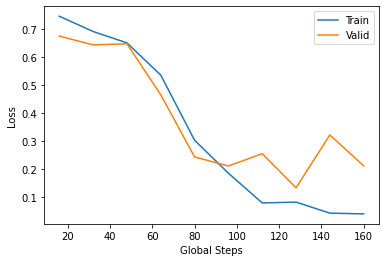

In [59]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [ ]:
# TODO- Task-2 

# Define evaluation funvtion

In [60]:
# Evaluation Function

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, title, text, titletext), _ in test_loader:

                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                titletext = titletext.type(torch.LongTensor)  
                titletext = titletext.to(device)
                output = model(titletext, labels)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])

# Loading the evaluation function

In [ ]:
# TODO- Task-3 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== //model.pt


/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Classification Report:
              precision    recall  f1-score   support

           1     0.9578    0.8949    0.9253      2816
           0     0.9026    0.9611    0.9309      2854

    accuracy                         0.9282      5670
   macro avg     0.9302    0.9280    0.9281      5670
weighted avg     0.9300    0.9282    0.9281      5670



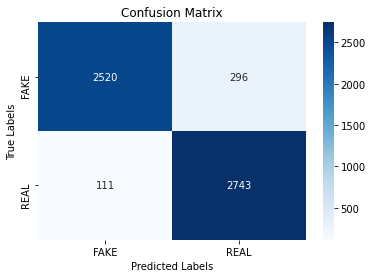

In [61]:
best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

evaluate(best_model, test_iter)

`After evaluating our model, we find that our model achieves an impressive accuracy of 96.99%!`




#Conclusion
We find that fine-tuning BERT performs extremely well on our dataset and is really simple to implement thanks to the open-source Huggingface Transformers library. This can be extended to any text classification dataset without any hassle.